In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
from matplotlib import pyplot as plt
from sklearn.model_selection import cross_val_score

from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import mae
from tensorflow.keras.metrics import Mean
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [2]:
try:
    df = pd.read_csv('data/card_transdata.csv')
except:
    df = pd.read_csv('creditcard.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
 #   Column                          Non-Null Count    Dtype  
---  ------                          --------------    -----  
 0   distance_from_home              1000000 non-null  float64
 1   distance_from_last_transaction  1000000 non-null  float64
 2   ratio_to_median_purchase_price  1000000 non-null  float64
 3   repeat_retailer                 1000000 non-null  float64
 4   used_chip                       1000000 non-null  float64
 5   used_pin_number                 1000000 non-null  float64
 6   online_order                    1000000 non-null  float64
 7   fraud                           1000000 non-null  float64
dtypes: float64(8)
memory usage: 61.0 MB


In [4]:
any(df.isna().sum() > 0)

False

In [5]:
df.describe()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,26.628792,5.036519,1.824182,0.881536,0.350399,0.100608,0.650552,0.087403
std,65.390784,25.843093,2.799589,0.323157,0.477095,0.300809,0.476796,0.282425
min,0.004874,0.000118,0.004399,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.878008,0.296671,0.475673,1.000000,0.000000,0.000000,0.000000,0.000000
50%,9.967760,0.998650,0.997717,1.000000,0.000000,0.000000,1.000000,0.000000
75%,25.743985,3.355748,2.096370,1.000000,1.000000,0.000000,1.000000,0.000000
max,10632.723672,11851.104565,267.802942,1.000000,1.000000,1.000000,1.000000,1.000000


In [6]:
df['fraud'].value_counts()

fraud
0.0    912597
1.0     87403
Name: count, dtype: int64

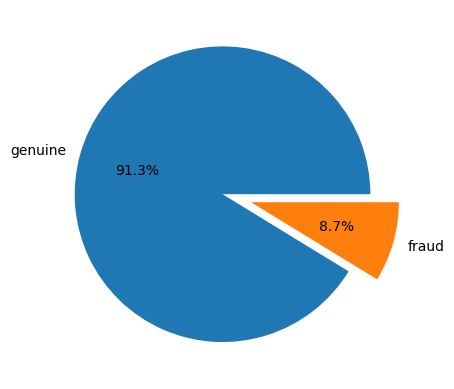

In [7]:
vc = df['fraud'].value_counts(ascending=False)

plt.pie(x=vc.values, labels=['genuine','fraud'], explode=[0.0, 0.2], autopct='%1.1f%%')
plt.show()

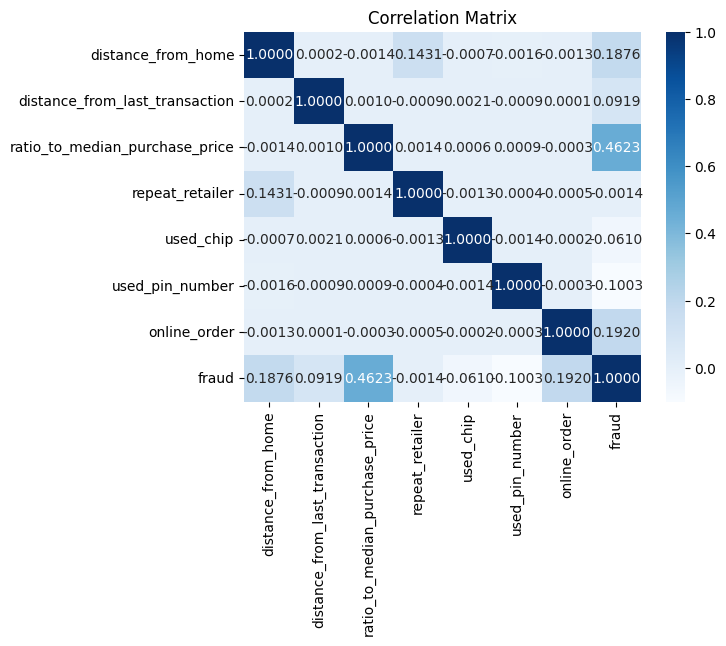

In [8]:
sns.heatmap(df.corr(), annot=True, fmt='.4f', cmap='Blues')
plt.title('Correlation Matrix')
plt.show()

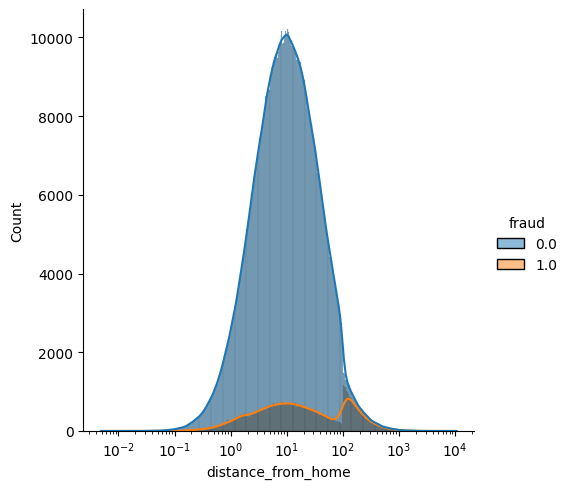

In [9]:
sns.displot(data=df, x='distance_from_home', hue='fraud', log_scale=True, kde=True)
plt.show()

Feature

In [10]:
cat_feats = [x for x in df.columns if len(df[x].unique()) <=2]
num_feats = [x for x in df.columns if x not in cat_feats]

In [11]:
ct = make_column_transformer(
    (StandardScaler(), num_feats)
)

df_scaled = pd.DataFrame(ct.fit_transform(df), columns=num_feats)
df_cat_feats = df[cat_feats]

df_concat = pd.concat([df_scaled, df_cat_feats], axis=1)
df_concat.head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,0.477882,-0.182849,0.043491,1.0,1.0,0.0,0.0,0.0
1,-0.241607,-0.188094,-0.189300,1.0,0.0,0.0,0.0,0.0
2,-0.329369,-0.163733,-0.498812,1.0,0.0,0.0,1.0,0.0
3,-0.372854,0.021806,-0.522048,1.0,1.0,0.0,1.0,0.0
4,0.268572,-0.172968,0.142373,1.0,1.0,0.0,1.0,0.0


In [12]:
X = df_concat.drop(['fraud'], axis=1)
y = df_concat['fraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=40)

y_train = y_train.astype(bool)
y_test = y_test.astype(bool)

X_train_genuine = X_train[~y_train]
X_test_genuine = X_test[~y_test]

X_train_fraud = X_train[y_train]
X_test_fraud = X_test[y_test]

Model

In [13]:
CODE_DIM = 2
INPUT_SHAPE = X_train.shape[1]

input_layer = Input(shape=(INPUT_SHAPE,))
x = Dense(64, activation='relu')(input_layer)
x = Dense(16, activation='relu')(x)
code = Dense(CODE_DIM, activation='relu')(x)
x = Dense(16, activation='relu')(code)
x = Dense(64, activation='relu')(x)
output_layer = Dense(INPUT_SHAPE, activation='relu')(x)

autoencoder = Model(input_layer, output_layer, name='anomaly')

In [15]:
model_name = "anomaly.weights.h5"
checkpoint = ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            save_weights_only=True,
                            verbose=1)
earlystopping = EarlyStopping(monitor='val_loss',
                              min_delta = 0, 
                              patience = 5, 
                              verbose = 1,
                              restore_best_weights=True)

callbacks = [checkpoint, earlystopping]

In [16]:
autoencoder.compile(loss='mae',
                    optimizer=Adam())

In [17]:
history = autoencoder.fit(X_train_genuine, X_train_genuine,
                          epochs=25, batch_size=64,
                          validation_data=(X_test, X_test),
                          callbacks=callbacks, shuffle=True)

Epoch 1/25
11408/11408 ━━━━━━━━━━━━━━━━━━━━ 0s 603us/step - loss: 0.2243
Epoch 1: val_loss improved from inf to 0.23680, saving model to anomaly.weights.h5
11408/11408 ━━━━━━━━━━━━━━━━━━━━ 9s 725us/step - loss: 0.2243 - val_loss: 0.2368
Epoch 2/25
11394/11408 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.2147
Epoch 2: val_loss improved from 0.23680 to 0.23664, saving model to anomaly.weights.h5
11408/11408 ━━━━━━━━━━━━━━━━━━━━ 8s 691us/step - loss: 0.2147 - val_loss: 0.2366
Epoch 3/25
11332/11408 ━━━━━━━━━━━━━━━━━━━━ 0s 572us/step - loss: 0.2141
Epoch 3: val_loss improved from 0.23664 to 0.22951, saving model to anomaly.weights.h5
11408/11408 ━━━━━━━━━━━━━━━━━━━━ 8s 683us/step - loss: 0.2141 - val_loss: 0.2295
Epoch 4/25
11396/11408 ━━━━━━━━━━━━━━━━━━━━ 0s 586us/step - loss: 0.2061
Epoch 4: val_loss improved from 0.22951 to 0.22317, saving model to anomaly.weights.h5
11408/11408 ━━━━━━━━━━━━━━━━━━━━ 8s 699us/step - loss: 0.2061 - val_loss: 0.2232
Epoch 5/25
11378/11408 ━━━━━━━━━━━━━━━━━

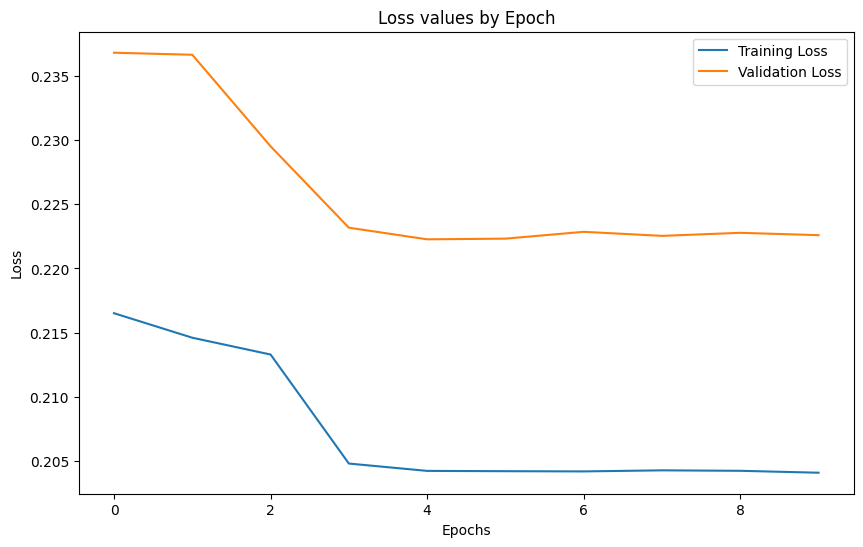

In [18]:
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'], label="Training Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title("Loss values by Epoch")
plt.show()

reconstruct


In [19]:
reconstructions = autoencoder.predict(X_test, verbose=0)
reconstruction_error = mae(reconstructions, X_test)

In [20]:
recons_df = pd.DataFrame({
    'error': reconstruction_error,
    'y_true': y_test
}).reset_index(drop=True)
recons_df.head()

,error,y_true
0,0.115445,False
1,0.060486,False
2,0.302407,True
3,0.096656,False
4,0.291358,False


In [22]:
threshold = thresh_df[thresh_df['recall'] == thresh_df['recall'].max()]['threshold'].values[0]
print(f"Threshold with Maximum Recall: {threshold:.6f}")

Threshold with Maximum Recall: 0.287783


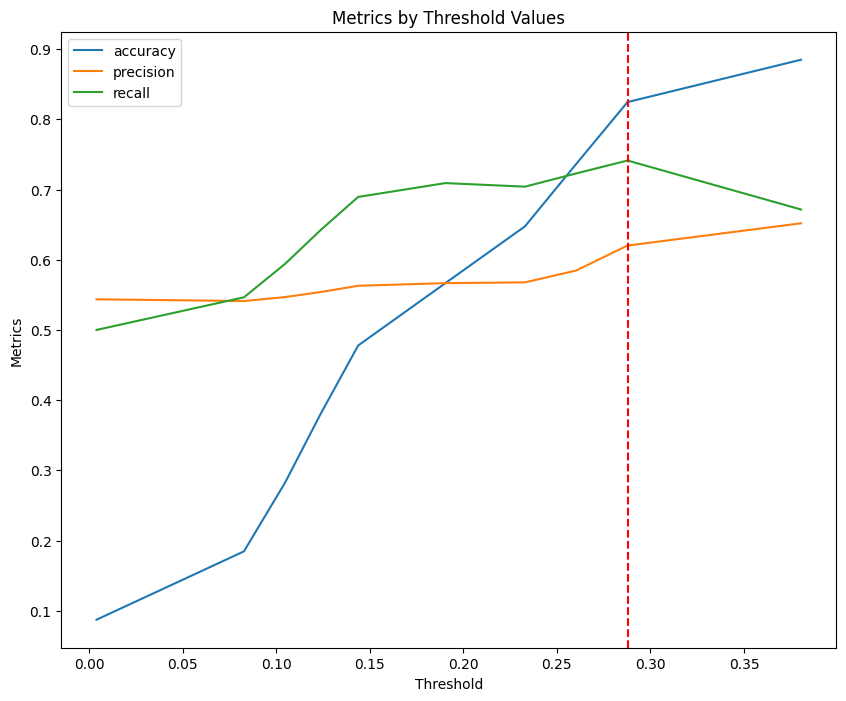

In [23]:
plt.figure(figsize=(10,8))
plt.plot(thresh_df['threshold'], thresh_df['accuracy'], label='accuracy')
plt.plot(thresh_df['threshold'], thresh_df['precision'], label='precision')
plt.plot(thresh_df['threshold'], thresh_df['recall'], label='recall')
plt.axvline(x=threshold, color='r', linestyle='dashed')
plt.xlabel('Threshold')
plt.ylabel('Metrics')
plt.title('Metrics by Threshold Values')
plt.legend()
plt.show()